# Mineria de Datos
## Trabajo practico 1


## Docentes
- Spetale Flavio 
- Vasquez Facundo 

## Integrantes
- Arenas Agustín
- Petetta Nicola


### Año 2024

# BIBLIOTECAS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
#from gap_statistic import OptimalK
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score,silhouette_samples, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn import decomposition
from sklearn import tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.preprocessing import LabelEncoder

pd.set_option("display.max_columns", 500)
#!pip install seaborn
#!pip install gap-stat

# DATASET: PokemonDB.csv

## DATOS

In [2]:
df = pd.read_csv("PokemonDB.csv")
df

Name      Type   HP  Attack  Defense  Sp. Atk  Sp. Def  Speed
0        Bulbasaur     Grass   45      49       49       65       65     45
1          Ivysaur     Grass   60      62       63       80       80     60
2         Venusaur     Grass   80      82       83      100      100     80
3         Venusaur     Grass   80     100      123      122      120     80
4       Charmander      Fire   39      52       43       60       50     65
...            ...       ...  ...     ...      ...      ...      ...    ...
1185        Chi-Yu      Dark   55      80       80      135      120    100
1186  Roaring Moon    Dragon  105     139       71       55      101    119
1187  Iron Valiant     Fairy   74     130       90      120       60    116
1188      Koraidon  Fighting  100     135      115       85      100    135
1189      Miraidon  Electric  100      85      100      135      115    135

[1190 rows x 8 columns]

## ESTRUCTURA GENERAL DEL DF

In [3]:
#Descripción general del DF
df.info()

#Tamaño del dataset (filas, columnas)
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Name     1190 non-null   object
 1   Type     1190 non-null   object
 2   HP       1190 non-null   int64 
 3   Attack   1190 non-null   int64 
 4   Defense  1190 non-null   int64 
 5   Sp. Atk  1190 non-null   int64 
 6   Sp. Def  1190 non-null   int64 
 7   Speed    1190 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 74.5+ KB


(1190, 8)

Tipo de datos:
* 2 son del tipo String
* 6 son del tipo Entero

Modificamos los nombres de las columnas para una manipulación algorítmica.

In [4]:
df.columns = df.columns.map(lambda x: x.lower().replace('.', '').replace(' ', '_'))

df.columns

Index(['name', 'type', 'hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed'], dtype='object')

## REVISION DE VALORES FALTANTES

In [5]:
#Vemos la cantidad de valores NaN por columna
df.isna().sum()

name       0
type       0
hp         0
attack     0
defense    0
sp_atk     0
sp_def     0
speed      0
dtype: int64

No hay valores faltantes en el dataset

## ATRIBUTO: TYPE

In [6]:
#Cantidad de valores distintos
df.type.nunique()

18

In [7]:
#Nombre de cada clase única
df.type.unique()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Dark', 'Poison',
       'Electric', 'Ground', 'Ice', 'Fairy', 'Steel', 'Fighting',
       'Psychic', 'Rock', 'Ghost', 'Dragon', 'Flying'], dtype=object)

Distribución de los datos respecto a las clases

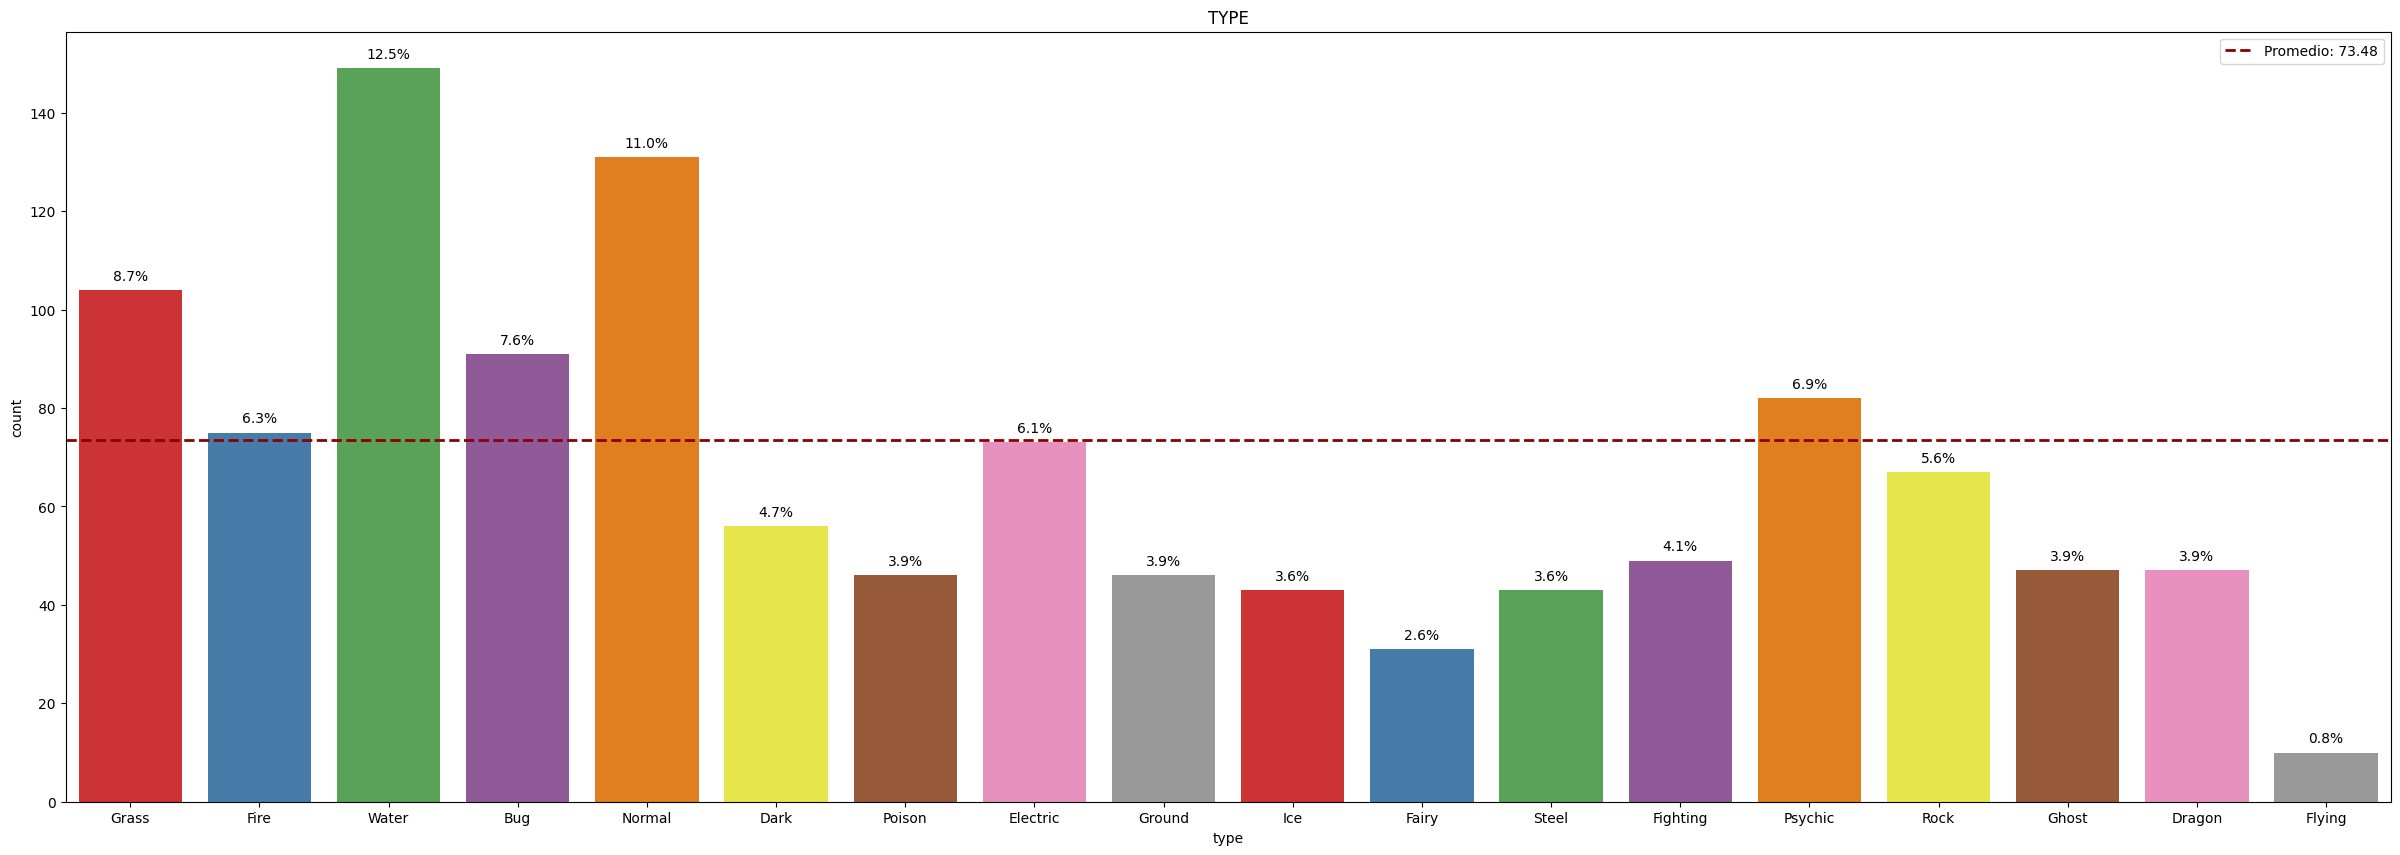

In [8]:
plt.figure(figsize=(30,10))

palette = "Set1"

ax = sns.countplot( x='type', data=df, palette=palette, hue='type', legend=False)

# Añadir anotaciones con porcentajes
total = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# Calcular el promedio de las columnas numéricas
numeric_columns = df.describe().columns
average_value = df[numeric_columns].mean().mean()

# Añadir una línea horizontal que represente el promedio de los valores numéricos
plt.axhline(y=average_value, color='darkred', linestyle='--', linewidth=2, label=f'Promedio: {average_value:.2f}')
plt.legend()

plt.title('TYPE')
plt.show()

Respecto al promedio se observa de los 18 Types:
* 5 superan el promedio de cantidad de datos, liderando el máximo Water
* 2 son aproximadamente igual al promedio
* 11 son inferiores al promedio, liderando el mínimo Flying

## DISTRIBUCION DE LOS DATOS Y VALORES ATIPICOS

In [9]:
# Resumen estadístico
df.describe().round(2)

hp   attack  defense   sp_atk   sp_def   speed
count  1190.00  1190.00  1190.00  1190.00  1190.00  1190.0
mean     70.85    80.96    74.59    72.76    72.05    69.7
std      26.89    32.12    30.72    32.66    27.64    30.2
min       1.00     5.00     5.00    10.00    20.00     5.0
25%      51.25    56.00    51.00    50.00    50.00    45.0
50%      70.00    80.00    70.00    65.00    70.00    67.0
75%      85.00   100.00    90.00    95.00    90.00    90.0
max     255.00   190.00   250.00   194.00   250.00   200.0

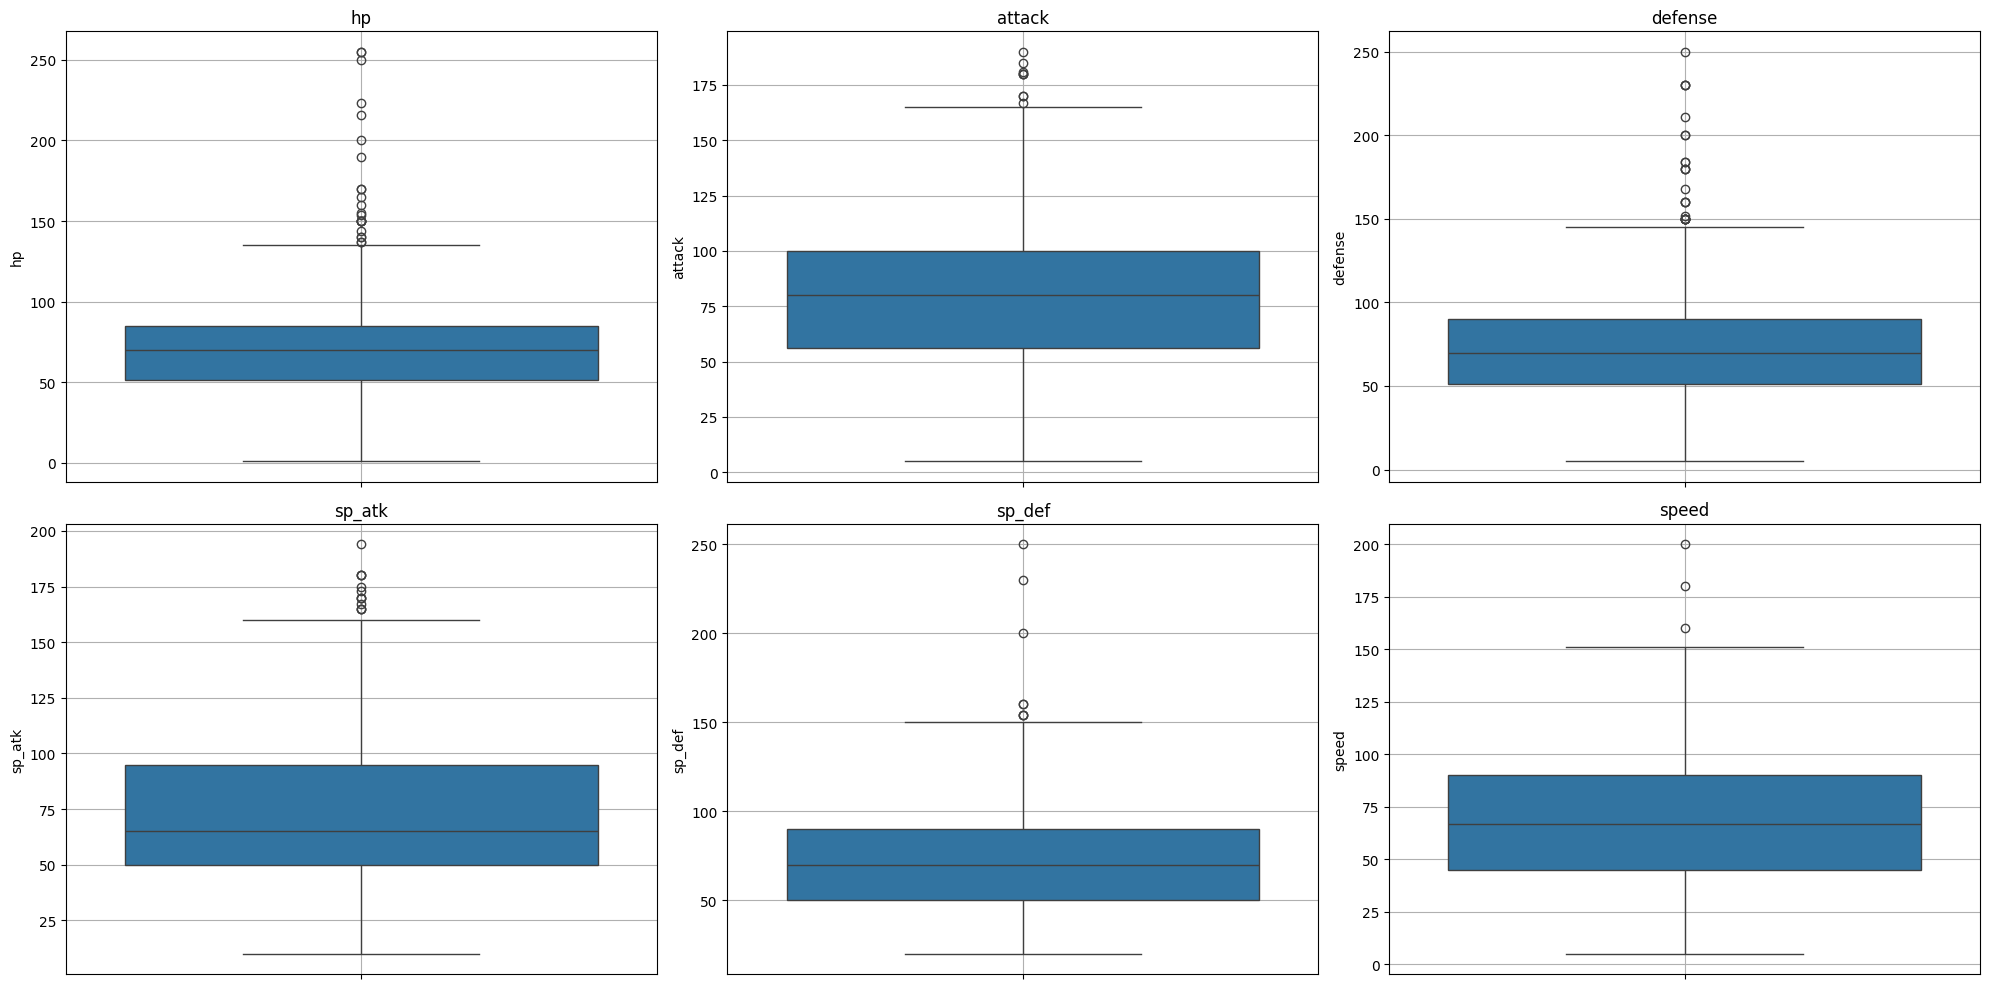

In [10]:
# Creamos una lista de columnas a graficar
columns_to_plot = df.describe().columns

# Número de columnas
n_cols = 3
n_rows = int(np.ceil(len(columns_to_plot) / n_cols))

# Figura y los ejes con n_rows filas y n_cols columnas
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5 * n_rows))

# Aplanamos los ejes para iterar fácilmente, en caso de que n_rows o n_cols sean mayores a 1
axes = axes.flatten()

# Iterar sobre cada columna y cada axis
for i, col in enumerate(columns_to_plot):
    sns.boxplot(data=df[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].grid(True)  # Mostrar la cuadrícula para cada boxplot
    axes[i].set_xticks([0])  # Establecer ticks fijos (asumiendo que solo hay un grupo en x)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

# Eliminar los ejes vacíos si hay menos gráficos que espacios de subplot
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el layout
plt.tight_layout()

# Mostrar los gráficos
plt.show()

Respecto a los valores atípicos, no hay valores lo suficiente extremos como para ser eliminados o corregidos.

**MATRIZ DE CORRELACION**

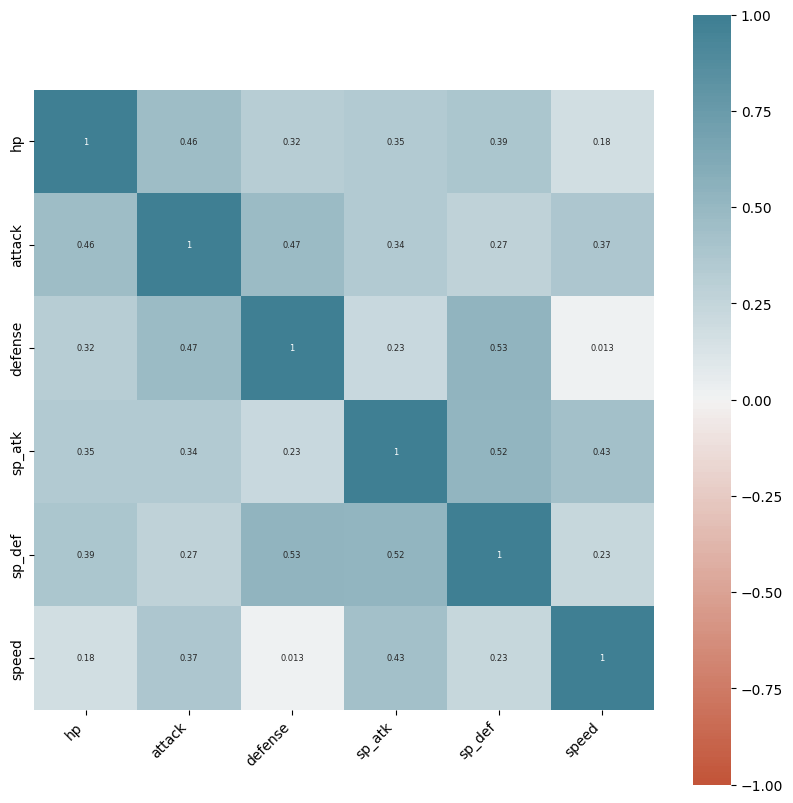

In [11]:
corr = df[df.describe().columns].corr()
plt.figure(figsize=(10,10))

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 6}
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

Todas las variables están correlacionadas de forma positiva

**PAIRPLOTS**

Observamos las clases distribuidas entre diferentes correlaciones de las variables.

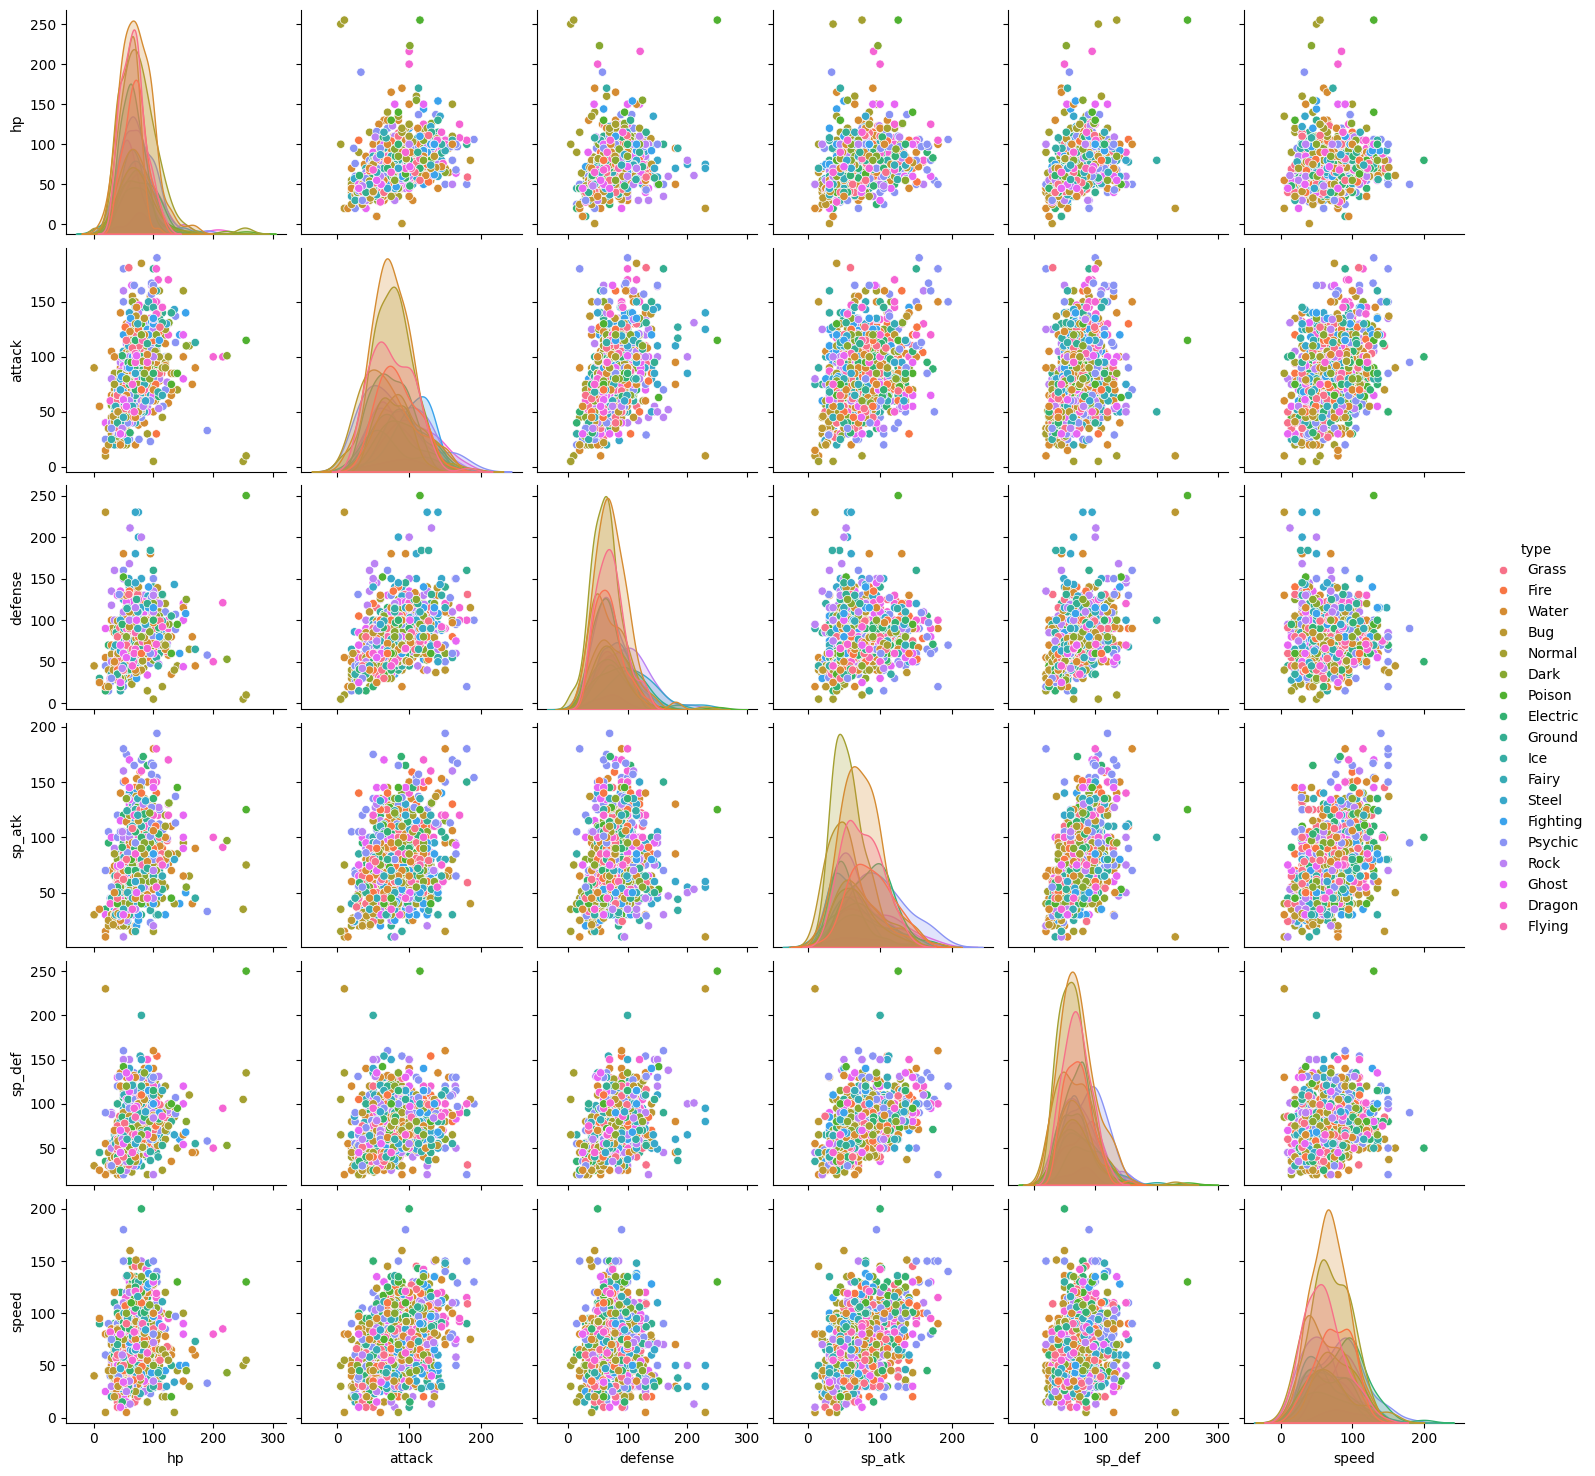

In [12]:
_ = sns.pairplot(df[df.describe().columns.tolist() + ['type']], diag_kind="kde", hue='type')

A simple vista no se detecta ningún patron notable de agrupamiento.

Se volverá a graficar pero dividiéndolo por grupos.

In [13]:
# Función para dividir las clases en grupos
def div_grupos(df, column, n_groups):
    # Obtener las clases únicas
    unique_classes = df[column].unique()
    
    # Calcular el tamaño de cada grupo
    group_size = len(unique_classes) // n_groups
    
    # Dividir las clases en grupos
    groups = [unique_classes[i:i + group_size] for i in range(0, len(unique_classes), group_size)]
    
    # Ajustar el último grupo si no se dividió exactamente
    if len(groups) > n_groups:
        last_group = groups.pop()
        groups[-1] = np.concatenate((groups[-1], last_group))
    
    return groups


# Supongamos que queremos 3 grupos
n_groups = 3
groups = div_grupos(df, 'type', n_groups)

groups

[array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Dark'], dtype=object),
 array(['Poison', 'Electric', 'Ground', 'Ice', 'Fairy', 'Steel'],
       dtype=object),
 array(['Fighting', 'Psychic', 'Rock', 'Ghost', 'Dragon', 'Flying'],
       dtype=object)]

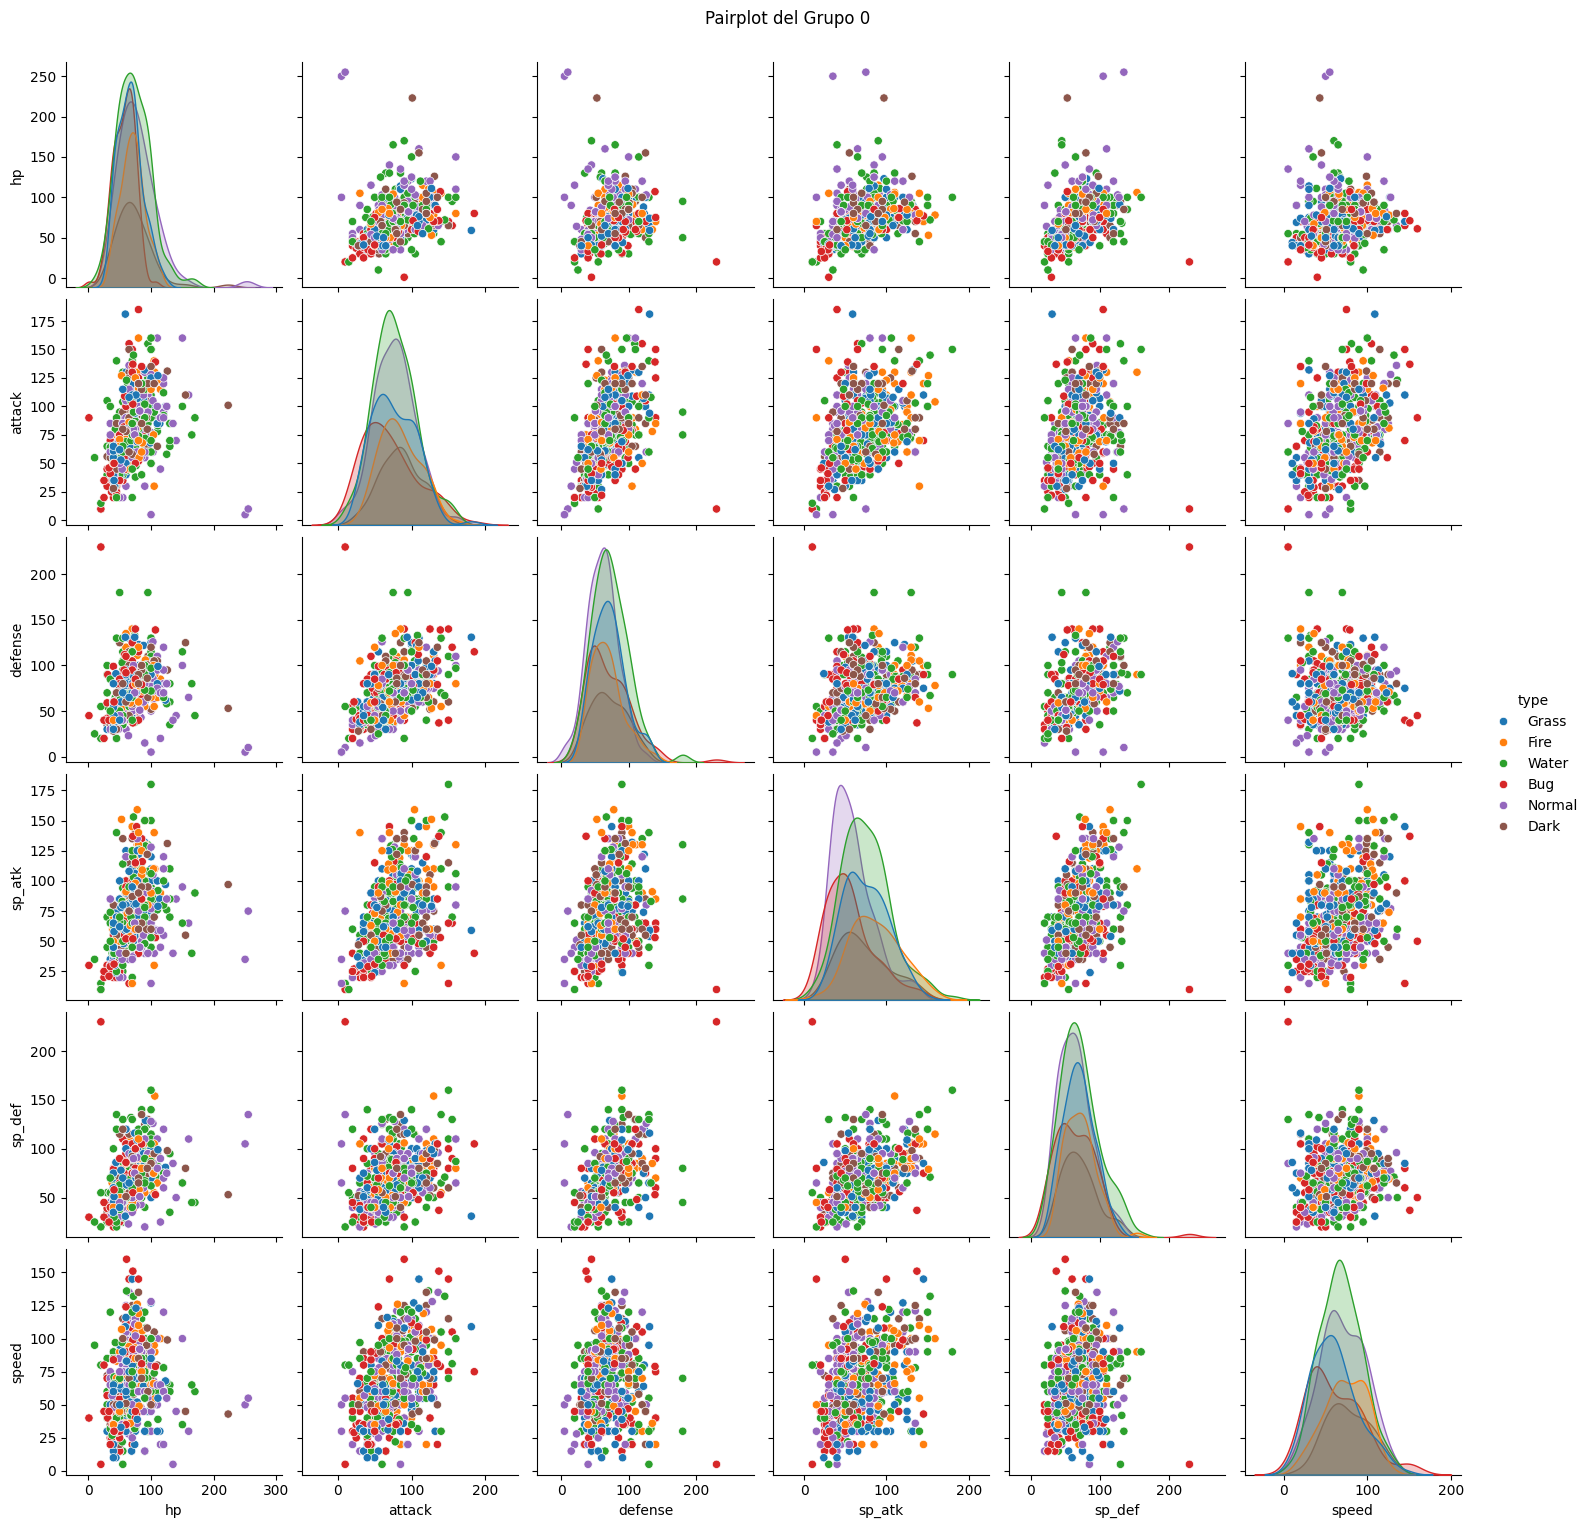

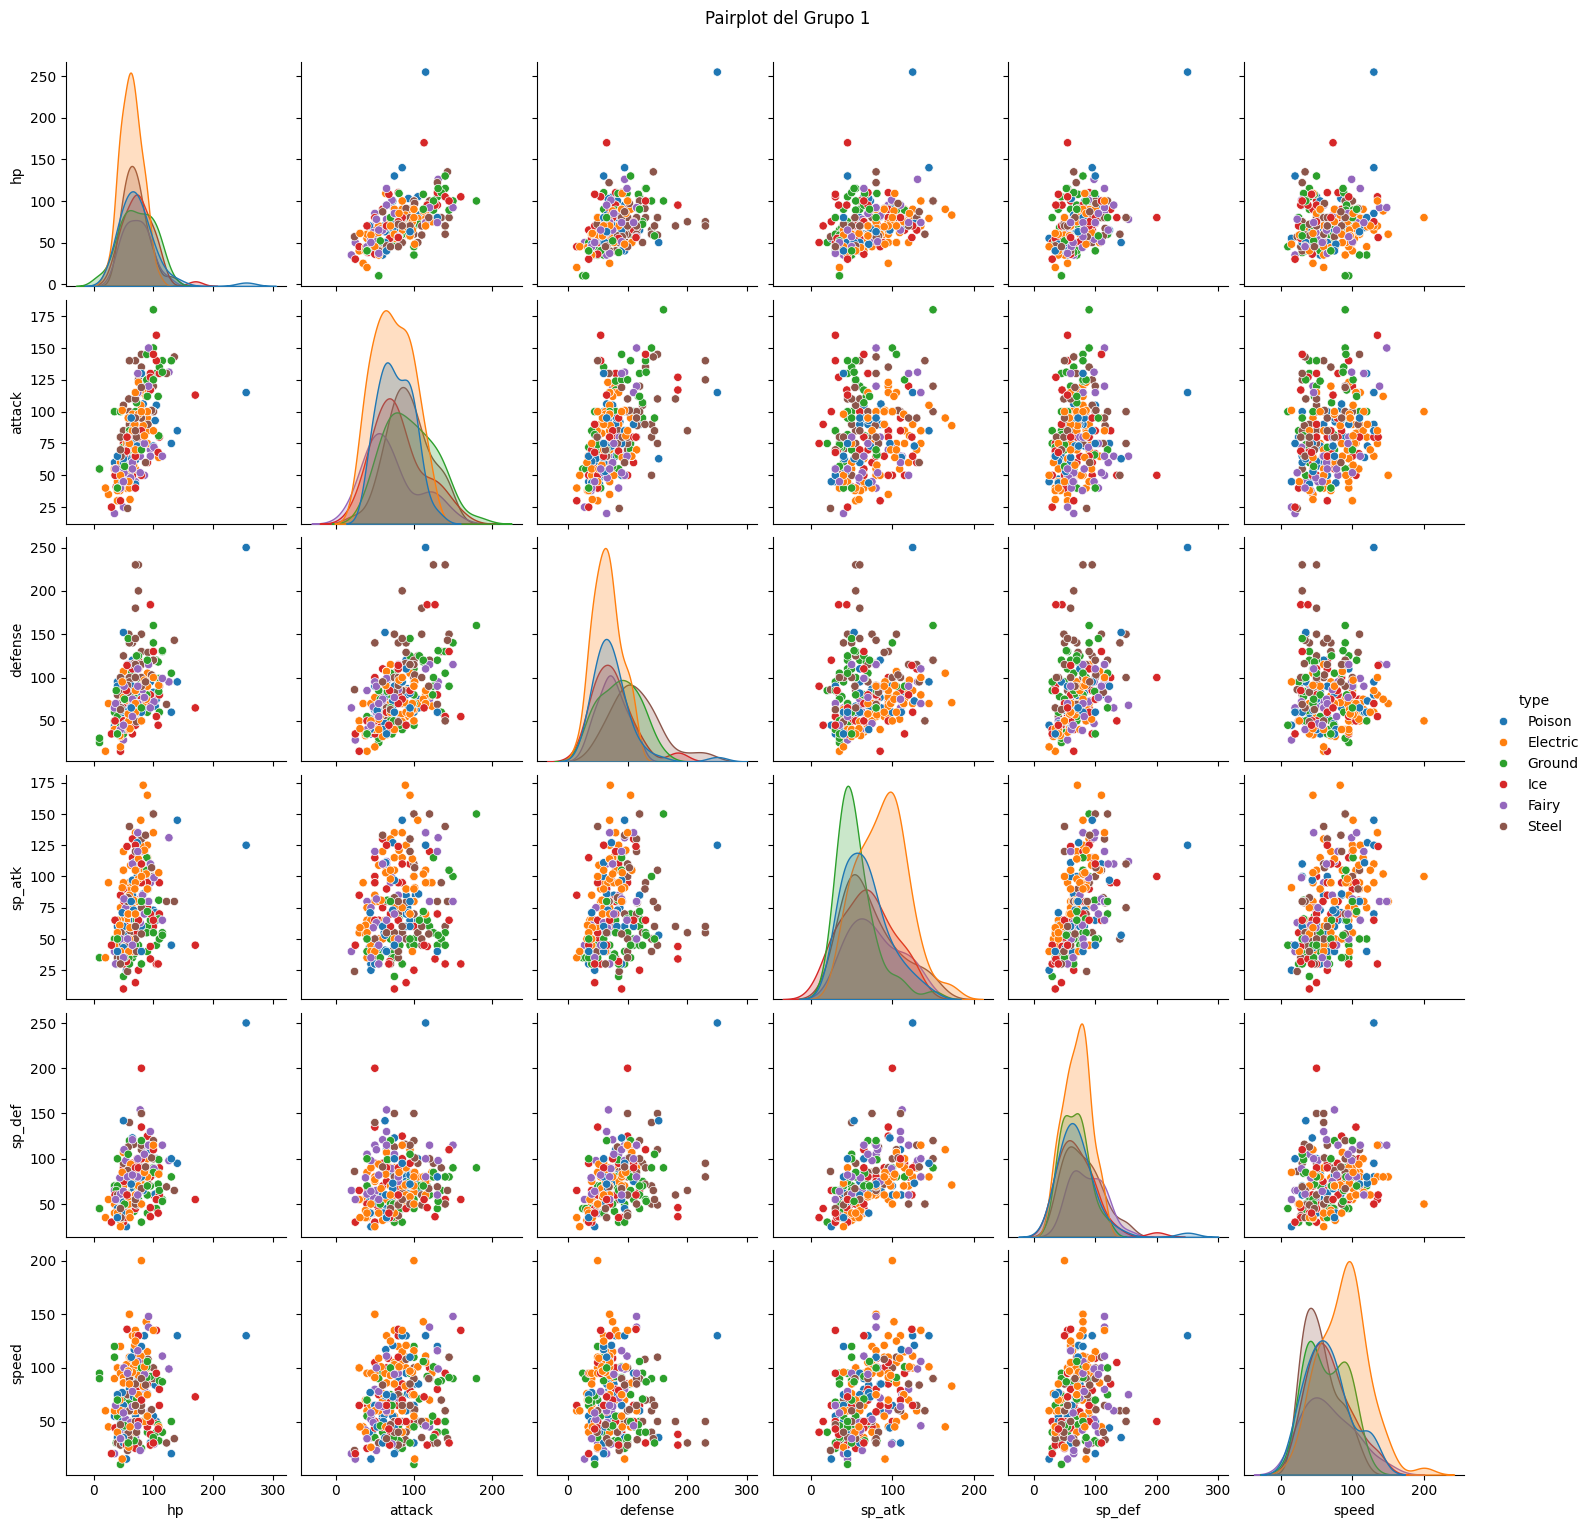

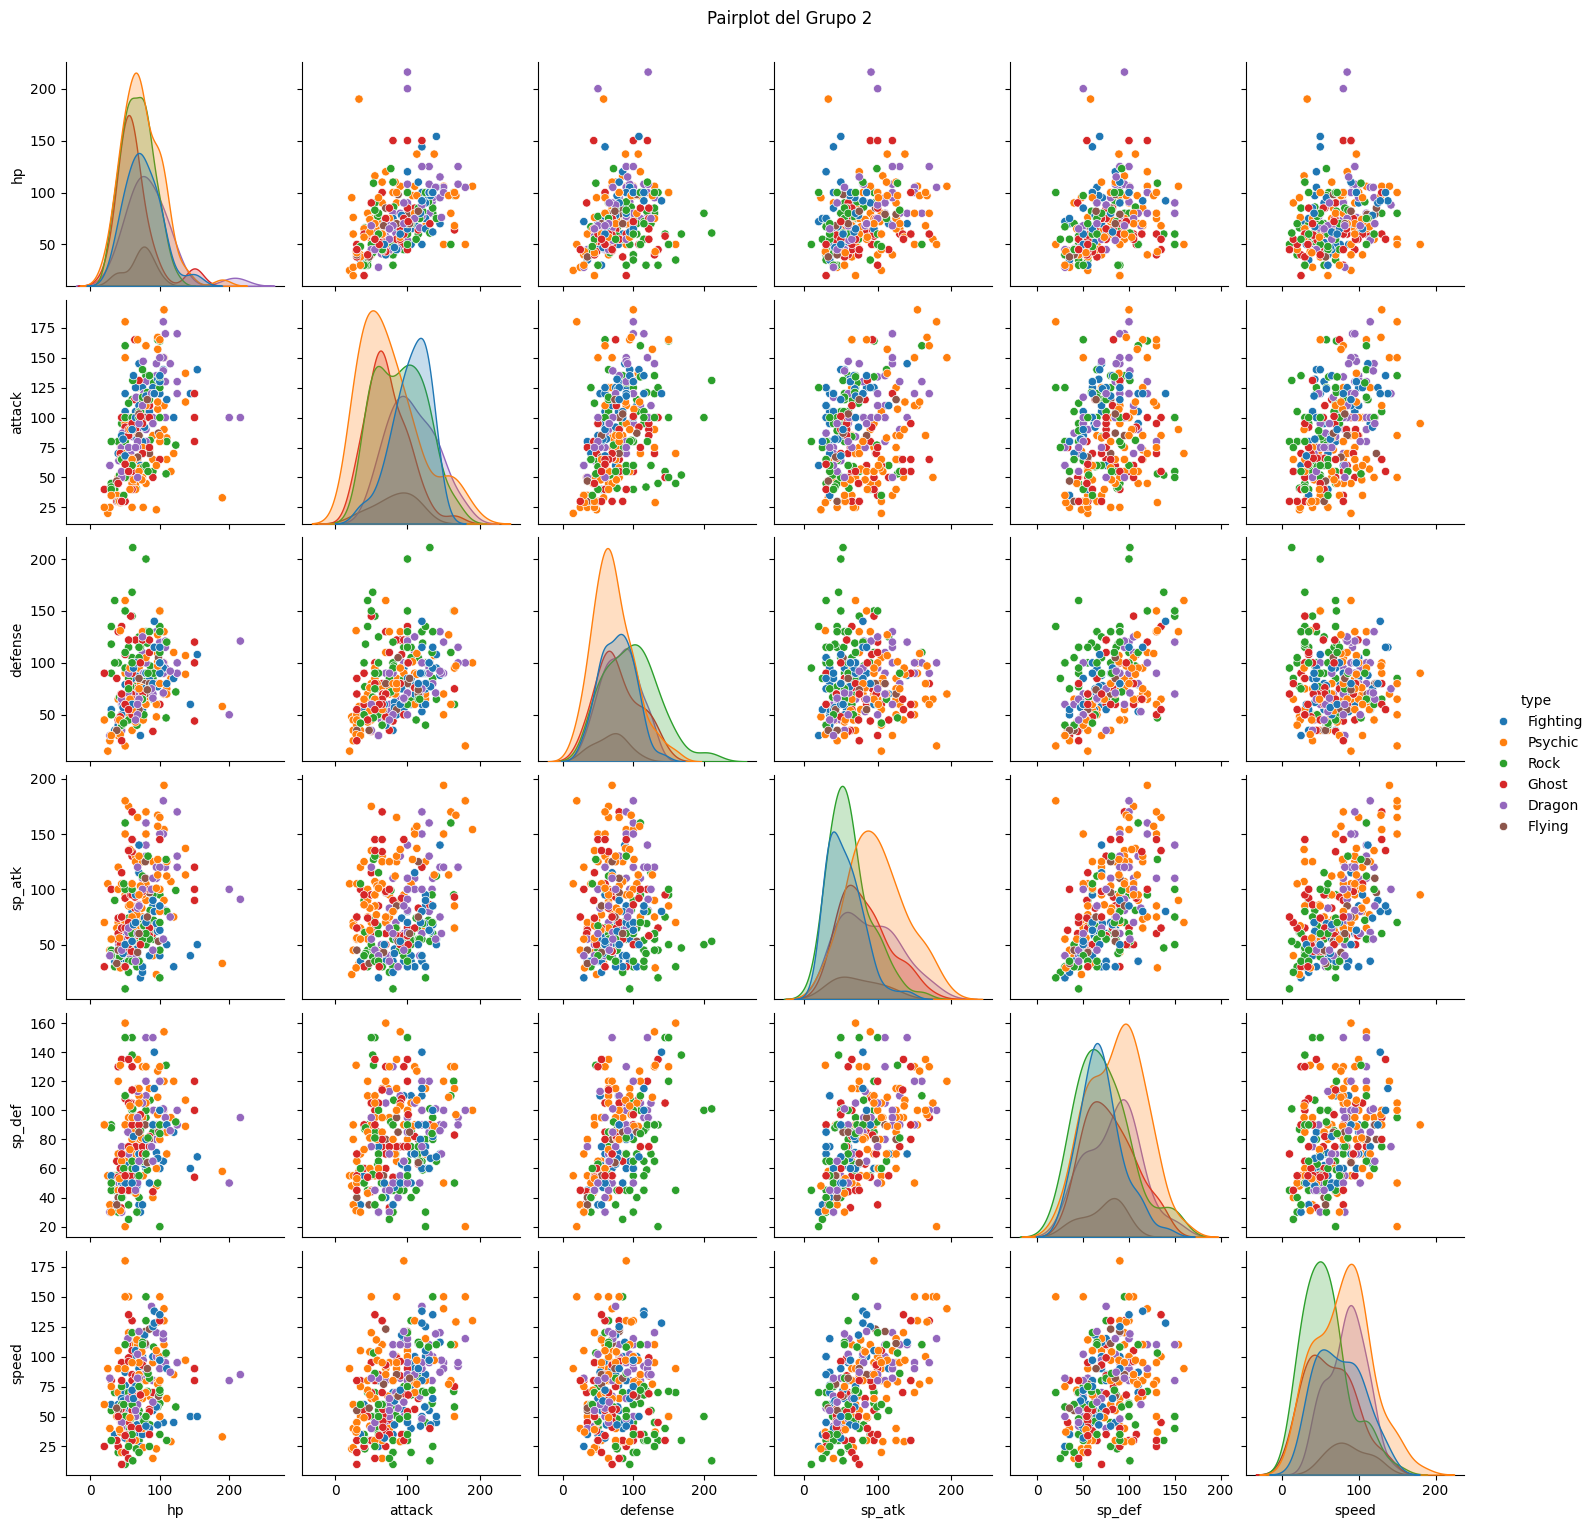

In [14]:
# Función para generar pairplots para cada grupo
def generate_pairplots(df, groups, numeric_columns):
    for i, group in enumerate(groups):
        df_group = df[df['type'].isin(group)]
    
        if not df_group.empty:
            sns.pairplot(df_group[numeric_columns + ['type']], diag_kind="kde", hue='type')
            plt.suptitle(f'Pairplot del Grupo {i}', y=1.02)
            plt.show()
        else:
            print(f"No hay datos en el grupo {i}")

# Asegurarse de obtener solo las columnas numéricas
numeric_columns = df.describe().columns.tolist()

# Crear los pairplots por cada grupo
generate_pairplots(df, groups, numeric_columns)

Ahora se puede identificar algunas características mas notables:
* En algunas gráficas se puede ver una tendencia a agruparse de forma lineal.
* En algunos casos se presentan picos altos de densidad y en otros casos picos bajos.
* En algunos casos la densidad es simétrica y en otros casos es asimétrica y/o irregular  

Todas basadas en datos agrupados por cada clase existente en Type.

Histograma completo de las variables, sin segregación por clases.

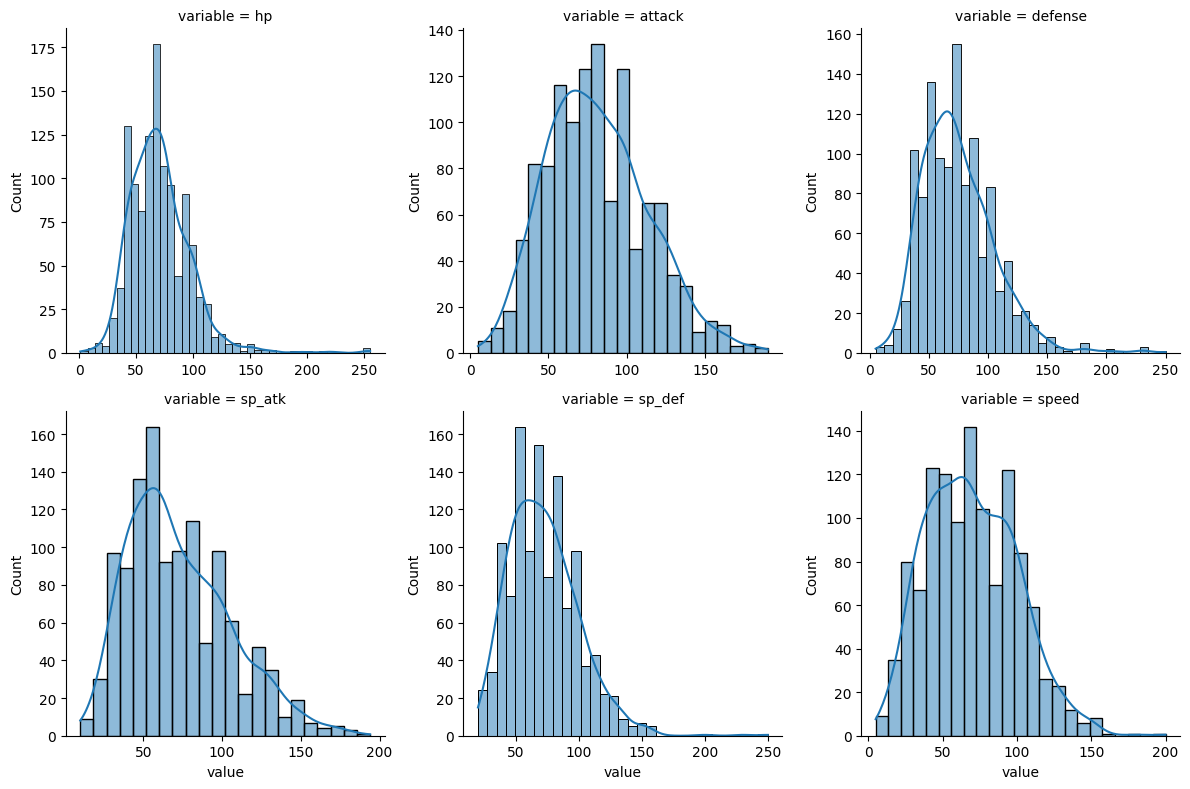

In [15]:
# Seleccionar solo las columnas numéricas
numeric_columns = df.describe().columns

# Convertir el DataFrame a formato largo (long format)
df_melted = df.melt(value_vars=numeric_columns)

# Crear la figura con un tamaño adecuado
g = sns.FacetGrid(df_melted, col="variable", col_wrap=3, height=4, sharex=False, sharey=False)
g.map(sns.histplot, "value", kde=True)

# Ajustar el layout para evitar solapamientos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

## MODELO: DECISION TREE

**TRAIN-TEST**

In [16]:
df_train, df_test  = train_test_split(df, test_size=0.3, random_state=33)

In [17]:
# Extraer las etiquetas (variable objetivo) de la columna 'type' en los DataFrames 'df_train' y 'df_test', y convertirlas en arreglos NumPy.
train_labels = np.array(df_train['type'])
test_labels = np.array(df_test['type'])

# Elimino las etiquetas para separar las características (variables independientes) de la variable objetivo.
df_train = df_train.drop(['name', 'type'], axis = 1)
df_test = df_test.drop(['name', 'type'], axis = 1)

# Lista de nombres de características extrayendo los nombres de columna del DataFrame 'df_train' para usarlos luego.
feature_list = list(df_train.columns)

# Convierte los DataFrames modificados (sin la columna 'type') es decir, las características (variables independientes) a array.
train_features = np.array(df_train)
test_features = np.array(df_test)

**MODELO: TREECLASSIFIER**

In [18]:
clf = tree.DecisionTreeClassifier()

In [19]:
# Entreno el modelo pasando las características de entrenamiento (train_features) y las etiquetas de entrenamiento correspondientes (train_labels).
decision_tree = clf.fit(train_features, train_labels)

# Predicción en el conjunto de entrenamiento.
clf_predictions_train = clf.predict(train_features)

# Predicción en el conjunto de prueba.
clf_predictions = clf.predict(test_features)

In [20]:
# Evaluó el rendimiento del modelo.
train_accuracy = accuracy_score(train_labels, clf_predictions_train)
test_accuracy = accuracy_score(test_labels, clf_predictions)

Es común que en arboles de clasificación, en el entrenamiento las métricas de un rendimiento mayor y que en el Test.

In [21]:
train_accuracy

0.9771908763505402

In [22]:
test_accuracy

0.20728291316526612

Esta diferencia de valores en los conjuntos de Train y Test, implica overfitting en el modelo.

C:\Users\PC\AppData\Local\Temp\ipykernel_7968\1261199099.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  gf = sns.barplot(data=features_df_sorted, x='importances', y ='features', palette="rocket")


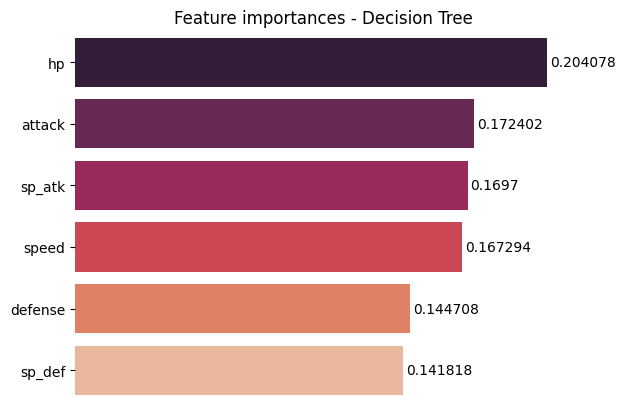

In [23]:
# Creamos un DF con dos columnas -> Característica y ganancia de información
features_df = pd.DataFrame({'features': feature_list, 'importances': decision_tree.feature_importances_ })

# Ordeno en base a la importancia
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

gf = sns.barplot(data=features_df_sorted, x='importances', y ='features', palette="rocket")
sns.despine(bottom = True, left = True)

gf.set_title('Feature importances - Decision Tree')
gf.set(xlabel=None)
gf.set(ylabel=None)
gf.set(xticks=[])
for value in gf.containers:
    gf.bar_label(value, padding=2)

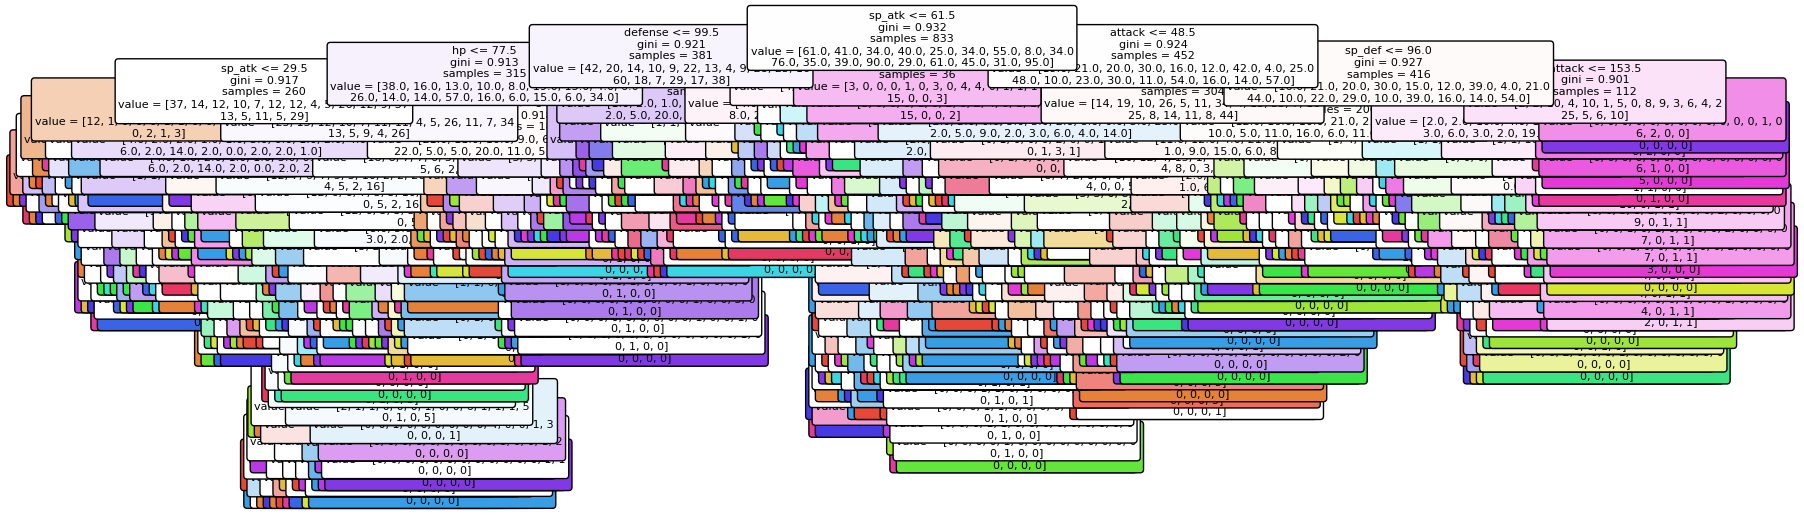

In [24]:
# Nombres de cada columna
features = feature_list

plt.figure(figsize=(20,6))
tree.plot_tree(decision_tree,
                feature_names=features,
                fontsize=8,
                filled=True,
                rounded=True)

plt.show()

## OPTIMIZACION DE HIPERPARAMETROS

In [25]:
# max_features: El número máximo de características a considerar para cada división. Suele ser la raíz cuadrada del número de características.
# max_depth: La profundidad máxima del árbol.
# random_state: Semilla para la generación de números aleatorios.
# min_samples_split: El número mínimo de muestras necesarias para dividir un nodo interno.

param_grid = {
    'max_features': [3, 5, 6, 7, 9, 11],
    'max_depth': [6, 9, 10, 11, 13],
    'random_state': [18]
}

random_search = RandomizedSearchCV(tree.DecisionTreeClassifier(), param_grid)

random_search.fit(train_features, train_labels)

# Mejores hiperparámetros encontrados durante la búsqueda aleatoria
first_best_params = random_search.best_params_

#Entrenamos el modelo con estos hiperparámetros
best_prediction = random_search.predict(test_features)
test_accuracy = accuracy_score(test_labels, best_prediction)

best_prediction_train = random_search.predict(train_features)
train_accuracy = accuracy_score(train_labels, best_prediction_train)


print(f'{first_best_params}')

train_accuracy = accuracy_score(train_labels, best_prediction_train)
print(f'Accuracy - Train: {train_accuracy}')

print(f'Accuracy - Test: {test_accuracy}')

{'random_state': 18, 'max_features': 6, 'max_depth': 6}
Accuracy - Train: 0.3157262905162065
Accuracy - Test: 0.16806722689075632


Si bien la métrica del entrenamiento disminuyo, si comparamos con el obtenido en test, se podría decir que el modelo ya no tiene el overfitting del modelo sin optimizar los HP.

**TEST**

In [26]:
#accuracy = accuracy_score(test_labels, clf_predictions).round(3)
#precision = precision_score(test_labels, clf_predictions, average='macro').round(3)
#recall = recall_score(test_labels, clf_predictions, average='macro').round(3)
#f1 = f1_score(test_labels, clf_predictions, average='macro').round(3)
confusion = confusion_matrix(test_labels, clf_predictions)

In [27]:
#print(f'Accuracy: {accuracy} \n\nPrecision: {precision} \n\nRecall: {recall} \n\nF1 {f1}')

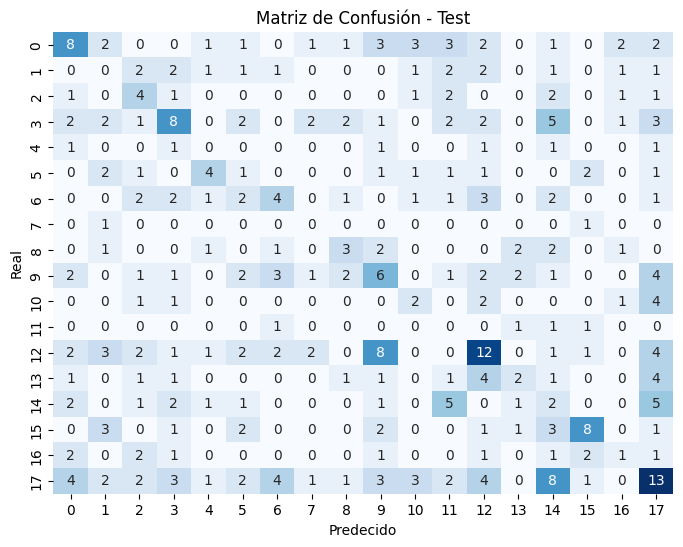

In [28]:
plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predecido')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Test')
plt.show()

La matriz de confusión ideal seria aquella que solo tiene valores en la diagonal. En este caso hay algunas clases en 0, es decir, directamente están todas mal clasificadas.

# Modelo Naive Bayes

#### Primero discretizar las variables

In [29]:
discretizar = ['hp','attack','defense','sp_atk','sp_def','speed']

bins = [1, 50, 100, 150, 200, 255]
labels = ['muy bajo', 'bajo', 'medio', 'alto', 'muy alto']

In [30]:
for atributo in discretizar:
    columna_procesada = f'{atributo}_discretizado'
    df[columna_procesada] = pd.cut(df[atributo], bins=bins, labels=labels, right=False)


Armar otro dataframe con las columnas discretizadas

In [31]:
dataframe = df.drop(['hp','attack','defense','sp_atk','sp_def','speed'], axis=1)

Las variables del modelo tienen que ser numericas asi que uso un label encoder para pasarlas

In [32]:
for columna in dataframe.columns:
    if columna != 'type':
        le = LabelEncoder()
        dataframe[columna] = le.fit_transform(dataframe[columna])

In [33]:
X = dataframe.drop(columns=['type'])
y = dataframe['type']

La variable a predecir tambien es codeada

In [34]:
label_encoder_type = LabelEncoder()
dataframe['type'] = label_encoder_type.fit_transform(dataframe['type'])

Formo 2 splits, uno 80/20 y otro 70/30 para comparar resultados

In [36]:
X_train_primero, X_test_primero, y_train_primero, y_test_primero = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
X_train_segundo, X_test_segundo, y_train_segundo, y_test_segundo = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
nb_classifier_primero = GaussianNB()
nb_classifier_primero.fit(X_train_primero, y_train_primero)

GaussianNB()

In [39]:
y_pred_primero = nb_classifier_primero.predict(X_test_primero)

precision = precision_score(y_test_primero, y_pred_primero, average='weighted')

recall = recall_score(y_test_primero, y_pred_primero, average='weighted')

accuracy = accuracy_score(y_test_primero, y_pred_primero)

print(f'Conjunto de test 1 - Precisión: {precision:.2f}')
print(f'Conjunto de test 1 - Exhaustividad: {recall:.2f}')
print(f'Conjunto de test 1 - Exactitud: {accuracy:.2f}')

Conjunto de test 1 - Precisión: 0.21
Conjunto de test 1 - Exhaustividad: 0.14
Conjunto de test 1 - Exactitud: 0.14


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
nb_classifier_segundo = GaussianNB()
nb_classifier_segundo.fit(X_train_segundo, y_train_segundo)

GaussianNB()

In [41]:
nb_classifier_segundo.fit(X_train_segundo, y_train_segundo)
y_pred_segundo = nb_classifier_segundo.predict(X_test_segundo)

In [42]:
precision_segundo = precision_score(y_test_segundo, y_pred_segundo, average='weighted')
recall_segundo = recall_score(y_test_segundo, y_pred_segundo, average='weighted')
accuracy_segundo = accuracy_score(y_test_segundo, y_pred_segundo)

print(f'Conjunto de test 2 - Precisión: {precision_segundo:.2f}')
print(f'Conjunto de test 2 - Exhaustividad: {recall_segundo:.2f}')
print(f'Conjunto de test 2 - Exactitud: {accuracy_segundo:.2f}')

Conjunto de test 2 - Precisión: 0.12
Conjunto de test 2 - Exhaustividad: 0.12
Conjunto de test 2 - Exactitud: 0.12


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### En conclusion:
Naive Bayes no se desempeña bien para predecir los tipos de pokemon, con los 2 splits los resultados son bajos lo que significa que directamente el modelo no esta siendo util para clasificar los tipos de pokemones

En el mapa de calor de las variables dependientes se puede observar que estas tienen una correlacion positiva entre si, esto en un clasificador como naive bayes no es tomado en cuenta ya que asume que cada una de estas variables contribuye de forma independiente a la prediccion del tipo

## MODELO: KNN

**Exploramos la target**

In [43]:
df.type.unique()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Dark', 'Poison',
       'Electric', 'Ground', 'Ice', 'Fairy', 'Steel', 'Fighting',
       'Psychic', 'Rock', 'Ghost', 'Dragon', 'Flying'], dtype=object)

In [44]:
# Crear el diccionario con las claves únicas
mapeo = {valor: i for i, valor in enumerate(df.type.unique())}
mapeo

{'Grass': 0,
 'Fire': 1,
 'Water': 2,
 'Bug': 3,
 'Normal': 4,
 'Dark': 5,
 'Poison': 6,
 'Electric': 7,
 'Ground': 8,
 'Ice': 9,
 'Fairy': 10,
 'Steel': 11,
 'Fighting': 12,
 'Psychic': 13,
 'Rock': 14,
 'Ghost': 15,
 'Dragon': 16,
 'Flying': 17}

In [45]:
# Mapeo de la Target y eliminación de la variable name
dfm = df.drop('name', axis=1).copy()
dfm['type'] = dfm['type'].map(mapeo)
dfm

type   hp  attack  defense  sp_atk  sp_def  speed hp_discretizado  \
0        0   45      49       49      65      65     45        muy bajo   
1        0   60      62       63      80      80     60            bajo   
2        0   80      82       83     100     100     80            bajo   
3        0   80     100      123     122     120     80            bajo   
4        1   39      52       43      60      50     65        muy bajo   
...    ...  ...     ...      ...     ...     ...    ...             ...   
1185     5   55      80       80     135     120    100            bajo   
1186    16  105     139       71      55     101    119           medio   
1187    10   74     130       90     120      60    116            bajo   
1188    12  100     135      115      85     100    135           medio   
1189     7  100      85      100     135     115    135           medio   

     attack_discretizado defense_discretizado sp_atk_discretizado  \
0               muy bajo             muy bajo                bajo   
1                   bajo                 bajo                bajo   
2                   bajo                 bajo               medio   
3                  medio                medio               medio   
4                   bajo             muy bajo                bajo   
...                  ...                  ...                 ...   
1185                bajo                 bajo               medio   
1186               medio                 bajo                bajo   
1187               medio                 bajo               medio   
1188               medio                medio                bajo   
1189                bajo                medio               medio   

     sp_def_discretizado speed_discretizado  
0                   bajo           muy bajo  
1                   bajo               bajo  
2                  medio               bajo  
3                  medio               bajo  
4                   bajo               bajo  
...                  ...                ...  
1185               medio              medio  
1186               medio              medio  
1187                bajo              medio  
1188               medio              medio  
1189               medio              medio  

[1190 rows x 13 columns]

**Preparación de los datos**

In [46]:
# Dividir el conjunto de datos en conjunto de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(dfm.drop('type', axis=1), dfm['type'], test_size=0.2, random_state=33)

# Estandarizar las características
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

ValueError: could not convert string to float: 'bajo'

In [ ]:
# Calcular la raíz cuadrada del número de elementos en x_train
raiz_cuadrada = np.sqrt(len(x_train))

# Imprimir el resultado
print("La raíz cuadrada del número de elementos en x_train es:", raiz_cuadrada)


**Modelo KNN**

In [ ]:
# Inicializar el clasificador KNN (K=30 en este caso)
knn_model = KNeighborsClassifier(n_neighbors=30)

# Entrenar el modelo
knn_model.fit(x_train, y_train)

In [ ]:
# Realizar predicciones en el conjunto de prueba
predictions = knn_model.predict(x_test)

# Mostrar el informe de clasificación
print('\nInforme de Clasificación:')
print(classification_report(y_test, predictions, zero_division=0))

**Precisión:** Para las diferentes clases varia desde un nivel alto como 0.67 a 0; para este caso predomina la mayoría como inferior a 0.5;
se podría decir que no hay buena precisión para la mayoría de las clases.

**Recall (Sensibilidad):** En esta métrica se observa una variación entre 0.54 a 0; predominando valores inferiores a 0.5; la mayoría de las clases tienen están siendo mal clasificadas.

**F1-Score:** La media armonica debido a los resultados anteriores equilibra ambas métricas quedando todos en valores inferiores a 0.5 como seria de esperar.

Se observaron valores nulos, procederemos a detectar que clases fueron.

In [ ]:
# Obtener las clases únicas presentes en y_test
clases_reales = np.unique(y_test)

# Obtener las clases únicas presentes en las predicciones
clases_predichas = np.unique(predictions)

# Encontrar las clases para las cuales no se hicieron predicciones
clases_sin_predicciones = np.setdiff1d(clases_reales, clases_predichas)

# Imprimir las clases sin predicciones
print("Clases sin predicciones:", clases_sin_predicciones)

In [ ]:
cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

En la matriz se observa aquellas Clases que no tienen ninguna predicción, ya sea porque no había de esa clase o porque fueron mal clasificadas.

**Métricas Promedio**

In [ ]:
# Calcular precision y recall
precision = precision_score(y_test, predictions, average='macro', zero_division=0)
recall = recall_score(y_test, predictions, average='macro', zero_division=0)

# Calcular el F1-score usando la fórmula
f1_score = 2 * (precision * recall) / (precision + recall)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, predictions)
print(f'Precisión del modelo: {accuracy:.2f}')

# Imprimir los resultados
print(f'Precisión: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1_score:.2f}')


La precisión del modelo es baja. Y las otras métricas reflejan una presencia mayoritaria de falsos positivos y falsos negativos.

## MODELO: GRIDSEARCHCV

In [ ]:
# Inicializar el clasificador KNN
knn_gscv = KNeighborsClassifier()

# Definir los parámetros a ajustar
p_gscv = {'n_neighbors': range(15, 46, 2),
          'p': [1,2],
          'weights': ['uniform', 'distance']}

# Inicializar el objeto GridSearchCV
grid_search = GridSearchCV(estimator=knn_gscv, param_grid=p_gscv, cv=5, scoring='accuracy')

In [ ]:
# Realizar la búsqueda de hiperparámetros en el conjunto de entrenamiento
grid_search.fit(x_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo entrenado
mejor_modelo = grid_search.best_estimator_

In [ ]:
# Realizar predicciones en el conjunto de prueba
pred = mejor_modelo.predict(x_test)

# Mostrar el informe de clasificación
print('\nInforme de Clasificación:')
print(classification_report(y_test, pred, zero_division=0))

Respecto al modelo sin optimizar no se observa una mejora apreciable.

In [ ]:
# Obtener las clases únicas presentes en y_test
clases_reales = np.unique(y_test)

# Obtener las clases únicas presentes en las predicciones
clases_predichas = np.unique(pred)

# Encontrar las clases para las cuales no se hicieron predicciones
clases_sin_predicciones_gs = np.setdiff1d(clases_reales, clases_predichas)

# Imprimir las clases sin predicciones
print("Clases sin predicciones:", clases_sin_predicciones_gs)

In [ ]:
cm_gscv = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(confusion_matrix=cm_gscv).plot()
plt.show()

In [ ]:
# Clases distintas presentes en el Test
y_test.nunique()

Si se puede destacar la disminución de clases sin predecir, antes eran 5 y ahora es 1; aunque solo fueron mal clasificadas.

**Métricas Promedio**

In [ ]:
# Calcular precision y recall
precision = precision_score(y_test, pred, average='macro', zero_division=0)
recall = recall_score(y_test, pred, average='macro', zero_division=0)

# Calcular el F1-score usando la fórmula
f1_score = 2 * (precision * recall) / (precision + recall)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, pred)
print(f'Precisión del modelo: {accuracy:.2f}')

# Imprimir los resultados
print(f'Precisión: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1_score:.2f}')

En promedio los valores mejoraron respecto al valor anterior de 0.17.

## CONCLUSIONES

KNN vs KNN-GS
* A pesar de la optimización no se tiene un buen modelo, por lo que se podría recurrir a un balanceo de las clases para mejorar el rendimiento.
* De todas las métricas la mas incrementada fue la precisión, esto sirve para los casos donde los falsos positivos son cruciales de evitar.
* Se podría decir que de las 18 clases, 13 por lo menos tienen buenas chances de ser clasificadas, mientras que las otras 5 no, ya que a lo sumo son falsos. 